# Capstone Project - The Battle of the Neighborhoods in Bangalore
#### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem

**Bangalore** is the capital of the Indian state of Karnataka. Real estate requires large sums of capital and is not as liquid as other investment avenues like mutual funds, stocks and bonds. Real estate investment in Bangalore is very tricky, not all investments are in profit. Locality is the most important factor for profitability in real estate investment. Proximity to amenities, peaceful conforming areas, neighborhood status, scenic views, etc. are major factors for residential property valuations. While proximity to markets, warehouses, transport hubs, freeways, tax-exempt areas, etc. play an important role for commercial property valuations.

Real estate investor should invest only if he/she is very sure about the commercial developments in that location and proximity to all amenities as its the backbone for one’s rentals and sales. At the same time, the investment should be affordable.

Its very challenge to a new real estate investor to find such lucrative area in such a big city. By looking at the above pros and cons of real estate investment, as a data scientist, provide a solution which should help to the investor to find the desirable place.

## Data Acquisition and Preprocessing

Obtained the following data along with Foursquare location data to solve the problem.

1. Latest Bangalore’s real estate prices data from Makaan.com which is an online real estate portal in India. The data has the following information:
    - **Locality Name** - various localities in Bangalore
    - **Price range per sqft** - Price range per square feet in INR
    - **Avg price per sqft** - Average price per square feet in INR
    - **Price rise** - Price rise in percentage
    - **Trend** - Price trend of each locality
2. Most common venues data of a given locality of Bangalore via Foursquare API

### Data Acquisition

**Import Required Libraries**

In [11]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

%matplotlib inline
import matplotlib.pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#! pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#! pip install folium
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [12]:
col_names = ['Locality','Price_range_per_sqft','Avg_price_per_sqft','Price_rise','Trend','View_properties']
raw_data = pd.DataFrame(columns=col_names) # Initalize empty dataframe.

In [13]:
for i in range(1,85):
    url = 'https://www.makaan.com/price-trends/property-rates-for-buy-in-bangalore?page='+str(i)
    try:
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[-3] # -3 for PLOT data
        df.columns = df.columns.get_level_values(0)
        df.columns = col_names        
        raw_data = raw_data.append(df, ignore_index = True)
    except:
        pass

del df

print("Data Collected")

Data Collected


In [14]:
#raw_data.to_excel("C:/Srinu/DataScienceIBM/AppliedDataScienceCapstone/CapstoneProjectNotebook/Coursera_Capstone/The Battle of Neighborhoods (Week 2)/raw_data.xlsx")

In [17]:
print("Raw Data Shape: ", raw_data.shape)
raw_data.head()

Raw Data Shape:  (4993, 6)


,Locality,Price_range_per_sqft,Avg_price_per_sqft,Price_rise,Trend,View_properties
0,HSR Layout,"113 - 28,000 / sqft","24,155.84 / sqft",69.1%,See trend,View 77 properties
1,Koramangala,"2,083 - 52,083 / sqft","51,391.56 / sqft",597.2%,See trend,View 52 properties
2,Jigani,"167 - 18,000 / sqft","17,19.65 / sqft",64.7%,See trend,View 1557 properties
3,Mahadevapura,"2,999 - 8,491 / sqft","5,744.78 / sqft",34.4%,See trend,View 2 properties
4,Whitefield Hope Farm Junction,"1,200 - 6,667 / sqft","6,286.02 / sqft",62.8%,See trend,View 31 properties


In [18]:
processed_data = raw_data.copy()

### Data Preprocessing

Remove unnecessary columuns except **Locality** and **Avg_price_per_sqft**

In [19]:
processed_data = processed_data[['Locality', 'Avg_price_per_sqft']]

Remove localities for which **Avg_price_per_sqft** not available

In [20]:
processed_data = processed_data[processed_data['Avg_price_per_sqft'] != '-'].reset_index(drop=True)

In [21]:
print("Now Data Shape: ", processed_data.shape)
processed_data.head()

Now Data Shape:  (869, 2)


,Locality,Avg_price_per_sqft
0,HSR Layout,"24,155.84 / sqft"
1,Koramangala,"51,391.56 / sqft"
2,Jigani,"17,19.65 / sqft"
3,Mahadevapura,"5,744.78 / sqft"
4,Whitefield Hope Farm Junction,"6,286.02 / sqft"


Remove unnecessary string in column **Avg_price_per_sqft** so that its data type as integer

In [22]:
def extract_price(text):    
    price = ''.join([c for c in text if c in '1234567890.'])
    return price

In [23]:
processed_data.Avg_price_per_sqft = processed_data['Avg_price_per_sqft'].apply(extract_price)
processed_data['Avg_price_per_sqft'] = processed_data['Avg_price_per_sqft'].astype(float).astype(int)

print("After above steps, Data Shape: ", processed_data.shape)
processed_data.head()

After above steps, Data Shape:  (869, 2)


,Locality,Avg_price_per_sqft
0,HSR Layout,24155
1,Koramangala,51391
2,Jigani,1719
3,Mahadevapura,5744
4,Whitefield Hope Farm Junction,6286


**Obtain Coordinates**

Used geopy to obtain coordinates of the localities in Bangalore.

In [24]:
list_lat = []   # create empty lists
list_long = []
for index, row in processed_data.iterrows(): # iterate over rows in dataframe
    area = row['Locality']
    city = 'Bangalore'
    address = str(area)+', '+str(city)
    try:        
        geolocator = Nominatim(timeout=10)
        results = geolocator.geocode(address)
        lat = results.latitude
        long = results.longitude
        list_lat.append(lat)
        list_long.append(long)
    except:
        lat = 0
        long = 0
        list_lat.append(lat)
        list_long.append(long)
        pass
    
# create new columns from lists
processed_data['Latitude'] = list_lat
processed_data['Longitude'] = list_long

C:\Users\s.x.parimi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [25]:
#processed_data.to_excel("C:/Srinu/DataScienceIBM/AppliedDataScienceCapstone/CapstoneProjectNotebook/Coursera_Capstone/The Battle of Neighborhoods (Week 2)/processed_data_coordinates.xlsx")

The geopy did not find coordinates for some of the localities. So, as a final data set called **bangalore_data**, took the localities which have proper coordinates.

In [26]:
bangalore_data = processed_data.copy()
bangalore_data = bangalore_data[bangalore_data['Latitude'] != 0].reset_index(drop=True)

print("Final Data Shape: ", bangalore_data.shape)
bangalore_data.head()

Final Data Shape:  (559, 4)


,Locality,Avg_price_per_sqft,Latitude,Longitude
0,HSR Layout,24155,12.911623,77.638862
1,Koramangala,51391,13.292399,77.751926
2,Jigani,1719,12.785253,77.638093
3,Mahadevapura,5744,12.993498,77.692416
4,Whitefield,11892,12.969637,77.749745


## Data Exploration

#### Map of Bangalore with its Localities/Neighborhoods

In [27]:
address = 'Bangalore, India'
geolocator = Nominatim(timeout=10)
location = geolocator.geocode(address)
lat_blr = location.latitude
long_blr = location.longitude
print('The geograpical coordinate of Bangalore home are {}, {}.'.format(lat_blr, long_blr))

C:\Users\s.x.parimi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of Bangalore home are 12.9791198, 77.5912997.


In [28]:
# Initiating a Folium map with Bangalore's longitude and latitude
map_blr = folium.Map(location=[lat_blr, long_blr], zoom_start=11)

# add markers to map
for lat, lng, locality in zip(bangalore_data['Latitude'], bangalore_data['Longitude'], bangalore_data['Locality']):
    label = '{}'.format(locality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blr)  
    
map_blr

**Descriptive Statistics**

In [29]:
bangalore_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 4 columns):
Locality              559 non-null object
Avg_price_per_sqft    559 non-null int32
Latitude              559 non-null float64
Longitude             559 non-null float64
dtypes: float64(2), int32(1), object(1)
memory usage: 15.4+ KB


In [30]:
bangalore_data.describe()

,Avg_price_per_sqft,Latitude,Longitude
count,559.000000,559.000000,559.000000
mean,7101.327370,13.005371,77.621759
std,7755.202593,0.132745,0.117395
min,32.000000,12.509896,76.828661
25%,2287.500000,12.918575,77.559327
50%,4456.000000,12.997803,77.620909
75%,9000.000000,13.065740,77.680577
max,61538.000000,13.439242,78.384778


**Top 5 localities with the highest average price per square feet**

In [31]:
bangalore_data.sort_values(['Avg_price_per_sqft'], ascending = False, axis = 0, inplace = True )
bangalore_data.head()

,Locality,Avg_price_per_sqft,Latitude,Longitude
380,Hesarghatta Main Road,61538,13.098223,77.532626
107,Thanisandra Main Road,56250,13.043249,77.625648
1,Koramangala,51391,13.292399,77.751926
204,Nagasandra,46875,13.047950,77.500135
297,MG Road,38359,12.974185,77.612414


Now Visualize them

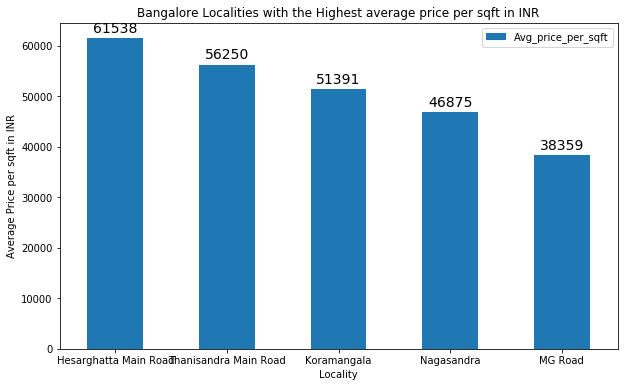

In [34]:
top = bangalore_data[['Locality','Avg_price_per_sqft']].head()

top.set_index('Locality',inplace = True)

ax = top.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Average Price per sqft in INR') # add to x-label to the plot
ax.set_xlabel('Locality') # add y-label to the plot
ax.set_title('Bangalore Localities with the Highest average price per sqft in INR') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

**Visualize bottom 5 localities with the lowest average price per square feet**

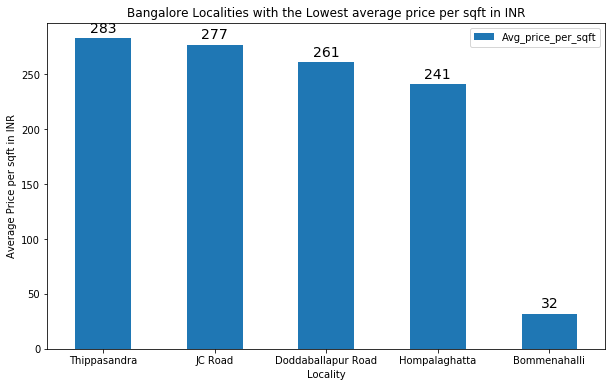

In [35]:
bottom = bangalore_data[['Locality','Avg_price_per_sqft']].tail()

bottom.set_index('Locality',inplace = True)

ax = bottom.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Average Price per sqft in INR') # add to x-label to the plot
ax.set_xlabel('Locality') # add y-label to the plot
ax.set_title('Bangalore Localities with the Lowest average price per sqft in INR') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

**Define Foursquare Credentials and Version**

In [36]:
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '***' # Foursquare API version

## Explore Neighborhoods in Bangalore

In [39]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood (or **Locality** ) and create a new dataframe called **blr_venues**

In [42]:
blr_venues = getNearbyVenues(names=bangalore_data['Locality'],
                                   latitudes=bangalore_data['Latitude'],
                                   longitudes=bangalore_data['Longitude']
                                  )

Hesarghatta Main Road
Thanisandra Main Road
Koramangala
Nagasandra
MG Road
Sadashiva Nagar
Off Cunningham Road
Jayanagar
Ulsoor
Cunningham Road
Palace Road
Dispensary Road
Indiranagar Defence Colony
Church Street
Basavanagudi
Frazer Town
Dollars Colony
5th Block
Sector 1 HSR Layout
Sampangiram Nagar
Indira Nagar
Malleswaram
Gandhi Nagar
HSR Layout
Jayanagara 2nd Block
Benson Town
Koramangala 4th Block
Rajajinagar
Richmond Town
2nd Phase JP Nagar
Adugodi
100 Feet Road
Kalyan Nagar
Defence Colony
Cottonpet
Vijayanagar
Lower Palace Orchards
Palace Guttahalli
Banashankari
Benson Town
Koramangala 6th Block
Shanti Nagar
Bilekahalli
Cooke Town
NR Colony
Phase 4
HBR Layout
BTM Layout 2nd Stage
Cooke Town
Hutchins Road
HRBR Layout
Hanumanthanagar Bangalore
RMV
BTM Layout
Brookefield
3rd Block HBR Layout
Deepanjali Nagar
Cox Town
Hulimavu
Nagarbhavi
C K Gardens
5th Main Road
Kathriguppe
Wheeler Road Extension
RR Nagar
Banaswadi
Jakkur
Kammanahalli
Kasturi Nagar
Railway Layout
R T Nagar
Ashok Nag

Hompalaghatta
Bommenahalli


In [43]:
blr_venues.to_excel("C:/Srinu/DataScienceIBM/AppliedDataScienceCapstone/CapstoneProjectNotebook/Coursera_Capstone/The Battle of Neighborhoods (Week 2)/blr_venues.xlsx")

**Size of the resulting dataframe**

In [44]:
print(blr_venues.shape)
blr_venues.head()

(3255, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hesarghatta Main Road,13.098223,77.532626,Kasipu,13.097443,77.532640,Indian Restaurant
1,Hesarghatta Main Road,13.098223,77.532626,The Sambhram Roost,13.096111,77.530959,Resort
2,Hesarghatta Main Road,13.098223,77.532626,Kalathur Farms,13.094973,77.534273,Farm
3,Thanisandra Main Road,13.043249,77.625648,Adyar Ananda Bhavan,13.041035,77.624513,Vegetarian / Vegan Restaurant
4,Thanisandra Main Road,13.043249,77.625648,PVR Cinemas Elements Mall,13.045222,77.626789,Multiplex


In [45]:
len(blr_venues['Neighborhood'].unique())

409

**How many venues were returned for each neighborhood?**

In [46]:
blr_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
100 Feet Road,9,9,9,9,9,9
2nd Phase JP Nagar,8,8,8,8,8,8
3rd Block HBR Layout,5,5,5,5,5,5
5 Cross Harohalli,9,9,9,9,9,9
5th Block,1,1,1,1,1,1
5th Main Road,5,5,5,5,5,5
5th Phase,5,5,5,5,5,5
8th Block Jayanagar,59,59,59,59,59,59
8th Phase JP Nagar,8,8,8,8,8,8


In [47]:
blr_venues.groupby('Neighborhood').count().shape

(409, 6)

**How many unique categories can be curated from all the returned venues?**

In [48]:
print('There are {} uniques categories.'.format(len(blr_venues['Venue Category'].unique())))

There are 233 uniques categories.


## Analyze Each Neighborhood

In [49]:
# one hot encoding
blr_onehot = pd.get_dummies(blr_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
blr_onehot['Neighborhood'] = blr_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [blr_onehot.columns[-1]] + list(blr_onehot.columns[:-1])
blr_onehot = blr_onehot[fixed_columns]

blr_onehot.head()

,Women's Store,ATM,Accessories Store,Afghan Restaurant,Airport Service,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Capitol Building,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hotel Pool,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Nursery School,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Print Shop,Pub,Punjabi Restaurant,Racecourse,Rajasthani Restaurant,Resort,Rest Area,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Swiss Restaurant,Taco Place,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel & Transport,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Hesarghatta Main Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [50]:
blr_onehot.shape

(3255, 233)

**Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [51]:
blr_grouped = blr_onehot.groupby('Neighborhood').mean().reset_index()
blr_grouped.head()

,Neighborhood,Women's Store,ATM,Accessories Store,Afghan Restaurant,Airport Service,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Capitol Building,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hotel Pool,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Nursery School,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Print Shop,Pub,Punjabi Restaurant,Racecourse,Rajasthani Restaurant,Resort,Rest Area,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Swiss Restaurant,Taco Place,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel & Transport,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,100 Feet Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [52]:
blr_grouped.shape

(409, 233)

**Print each neighborhood along with the top 5 most common venues**

In [53]:
num_top_venues = 5

for hood in blr_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = blr_grouped[blr_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----100 Feet Road----
                           venue  freq
0              Indian Restaurant  0.33
1                         Bakery  0.22
2              Kerala Restaurant  0.11
3  Vegetarian / Vegan Restaurant  0.11
4                           Café  0.11


----2nd Phase JP Nagar----
                     venue  freq
0        Indian Restaurant  0.25
1  South Indian Restaurant  0.12
2              Snack Place  0.12
3         Department Store  0.12
4                     Café  0.12


----3rd Block HBR Layout----
                     venue  freq
0              Coffee Shop   0.2
1                     Road   0.2
2                     Café   0.2
3  North Indian Restaurant   0.2
4  South Indian Restaurant   0.2


----5 Cross Harohalli----
               venue  freq
0        Pizza Place  0.22
1  Indian Restaurant  0.22
2      Shopping Mall  0.11
3             Bakery  0.11
4            Theater  0.11


----5th Block----
                           venue  freq
0  Vegetarian / Vegan Restaurant   1.0


                  venue  freq
0                  Café   0.3
1     Indian Restaurant   0.2
2           Pizza Place   0.1
3         Shopping Mall   0.1
4  Fast Food Restaurant   0.1


----BK Halli Road----
                venue  freq
0  Chinese Restaurant   0.5
1         Supermarket   0.5
2       Women's Store   0.0
3        Noodle House   0.0
4               Motel   0.0


----BSK 6th Stage----
               venue  freq
0    Badminton Court  0.17
1        Snack Place  0.17
2  Indian Restaurant  0.17
3   Department Store  0.17
4       Tennis Court  0.17


----BTM Layout----
                venue  freq
0   Indian Restaurant  0.21
1      Ice Cream Shop  0.09
2              Bakery  0.09
3         Snack Place  0.09
4  Chinese Restaurant  0.06


----BTM Layout 2nd Stage----
               venue  freq
0  Indian Restaurant  0.21
1             Bakery  0.10
2        Snack Place  0.08
3        Coffee Shop  0.05
4               Café  0.05


----Babusabpalya----
                venue  freq
0        

                     venue  freq
0        Indian Restaurant   0.5
1                  Dog Run   0.5
2            Women's Store   0.0
3  North Indian Restaurant   0.0
4          Motorcycle Shop   0.0


----Byrathi Village----
                     venue  freq
0        Indian Restaurant   0.5
1                  Dog Run   0.5
2            Women's Store   0.0
3  North Indian Restaurant   0.0
4          Motorcycle Shop   0.0


----C K Gardens----
                  venue  freq
0                   ATM   0.2
1           Coffee Shop   0.2
2                Bakery   0.2
3                   Gym   0.2
4  Fast Food Restaurant   0.2


----Carmelaram----
               venue  freq
0      Train Station   1.0
1      Women's Store   0.0
2       Noodle House   0.0
3  Mobile Phone Shop   0.0
4              Motel   0.0


----Carmelaram Rd----
               venue  freq
0      Train Station   1.0
1      Women's Store   0.0
2       Noodle House   0.0
3  Mobile Phone Shop   0.0
4              Motel   0.0


----C

                     venue  freq
0        Indian Restaurant   0.5
1     Arts & Entertainment   0.5
2            Women's Store   0.0
3  North Indian Restaurant   0.0
4                    Motel   0.0


----Doddakannelli----
                 venue  freq
0    Indian Restaurant  0.50
1  Sporting Goods Shop  0.25
2   Seafood Restaurant  0.25
3        Women's Store  0.00
4            Nightclub  0.00


----Doddanekundi----
                      venue  freq
0                      Park  0.25
1         Indian Restaurant  0.25
2  Mediterranean Restaurant  0.25
3                      Lake  0.25
4             Women's Store  0.00


----Dollars Colony----
              venue  freq
0              Park  0.33
1  Department Store  0.33
2       Bus Station  0.33
3     Women's Store  0.00
4      Noodle House  0.00


----Dommasandra Village----
             venue  freq
0           Market   1.0
1    Women's Store   0.0
2     Noodle House   0.0
3            Motel   0.0
4  Motorcycle Shop   0.0


----East Banga

                       venue  freq
0                Coffee Shop  0.25
1                     Bakery  0.25
2                       Park  0.25
3                Pizza Place  0.25
4  Indian Chinese Restaurant  0.00


----Hosakerehalli Main Road----
               venue  freq
0                ATM  0.25
1           Pharmacy  0.25
2               Park  0.25
3  Indian Restaurant  0.25
4          Nightclub  0.00


----Hulimavu----
              venue  freq
0  Department Store  0.25
1        Restaurant  0.25
2   Badminton Court  0.25
3              Lake  0.25
4     Women's Store  0.00


----Hunasamaranahalli----
                     venue  freq
0        Indian Restaurant  0.50
1              Coffee Shop  0.25
2                     Lake  0.25
3  North Indian Restaurant  0.00
4          Motorcycle Shop  0.00


----Hutchins Road----
                venue  freq
0            Pharmacy  0.33
1                Café  0.17
2                Park  0.17
3  Chinese Restaurant  0.17
4       Grocery Store  0.17



                     venue  freq
0  South Indian Restaurant   0.2
1        Indian Restaurant   0.2
2         Department Store   0.2
3         Basketball Court   0.2
4                   Bakery   0.2


----Kogilu----
                           venue  freq
0                     Food Truck  0.25
1  Vegetarian / Vegan Restaurant  0.25
2           Fast Food Restaurant  0.25
3                           Lake  0.25
4                  Women's Store  0.00


----Kogilu Main Road----
                           venue  freq
0                     Food Truck  0.25
1  Vegetarian / Vegan Restaurant  0.25
2           Fast Food Restaurant  0.25
3                           Lake  0.25
4                  Women's Store  0.00


----Konadasapura----
                venue  freq
0                 Spa   1.0
1           Nightclub   0.0
2  Miscellaneous Shop   0.0
3   Mobile Phone Shop   0.0
4               Motel   0.0


----Konanakunte----
               venue  freq
0                ATM   0.5
1  Indian Restaurant   

                  venue  freq
0         Auto Workshop   0.5
1  Gym / Fitness Center   0.5
2         Women's Store   0.0
3                 Motel   0.0
4       Motorcycle Shop   0.0


----Nagavarapalya----
                  venue  freq
0  Fast Food Restaurant  0.11
1        Clothing Store  0.11
2           Pizza Place  0.07
3           Coffee Shop  0.07
4    Italian Restaurant  0.07


----Nagawara----
                           venue  freq
0                           Café   0.4
1                    Pizza Place   0.2
2  Vegetarian / Vegan Restaurant   0.2
3              Andhra Restaurant   0.2
4                   Noodle House   0.0


----Nallurahalli Road----
                     venue  freq
0                    Diner   0.5
1                     Lake   0.5
2            Women's Store   0.0
3  North Indian Restaurant   0.0
4          Motorcycle Shop   0.0


----Nandi Hills----
                     venue  freq
0     Karnataka Restaurant   1.0
1  North Indian Restaurant   0.0
2               

                  venue  freq
0     Indian Restaurant  0.20
1    Chinese Restaurant  0.12
2  Fast Food Restaurant  0.12
3        Ice Cream Shop  0.08
4    Athletics & Sports  0.04


----Ramamurthy Nagar----
               venue  freq
0   Department Store  0.25
1         Shoe Store  0.12
2  Electronics Store  0.12
3        Snack Place  0.12
4       Optical Shop  0.12


----Ramanashree California Gardens Layout----
                     venue  freq
0        Indian Restaurant   0.6
1              Coffee Shop   0.2
2                   Resort   0.2
3  North Indian Restaurant   0.0
4          Motorcycle Shop   0.0


----Richmond Town----
                venue  freq
0   Indian Restaurant  0.17
1               Hotel  0.09
2              Bakery  0.09
3  Chinese Restaurant  0.09
4         Coffee Shop  0.09


----Royal County Phase 1----
               venue  freq
0        Supermarket  0.25
1            Theater  0.25
2  Indian Restaurant  0.25
3         Racecourse  0.25
4      Moving Target  0.00


               venue  freq
0           Platform   1.0
1       Noodle House   0.0
2  Mobile Phone Shop   0.0
3              Motel   0.0
4    Motorcycle Shop   0.0


----Vaddarapalya----
              venue  freq
0     Boat or Ferry  0.25
1              Farm  0.25
2  Asian Restaurant  0.25
3              Lake  0.25
4      Noodle House  0.00


----Vakil Garden City----
             venue  freq
0      Gas Station   1.0
1    Women's Store   0.0
2     Noodle House   0.0
3            Motel   0.0
4  Motorcycle Shop   0.0


----Varanasi----
                  venue  freq
0     Convenience Store   0.5
1  Fast Food Restaurant   0.5
2         Women's Store   0.0
3          Noodle House   0.0
4                 Motel   0.0


----Varthur----
                     venue  freq
0         Department Store   1.0
1            Women's Store   0.0
2  North Indian Restaurant   0.0
3                    Motel   0.0
4          Motorcycle Shop   0.0


----Varthur Road----
                           venue  freq
0   

**Put that into a pandas dataframe**

First, let's write a function to sort the venues in descending order.

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = blr_grouped['Neighborhood']

for ind in np.arange(blr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blr_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100 Feet Road,Indian Restaurant,Bakery,Café,BBQ Joint,Kerala Restaurant,Vegetarian / Vegan Restaurant,Film Studio,Fast Food Restaurant,Farmers Market,Eastern European Restaurant
1,2nd Phase JP Nagar,Indian Restaurant,Fast Food Restaurant,Café,Diner,Department Store,South Indian Restaurant,Snack Place,Farmers Market,Farm,Dry Cleaner
2,3rd Block HBR Layout,South Indian Restaurant,Road,North Indian Restaurant,Café,Coffee Shop,Gym / Fitness Center,Diner,Farmers Market,Farm,Falafel Restaurant
3,5 Cross Harohalli,Indian Restaurant,Pizza Place,Bakery,Theater,Café,Shopping Mall,Tea Room,Fast Food Restaurant,Farmers Market,Farm
4,5th Block,Vegetarian / Vegan Restaurant,Wings Joint,Donut Shop,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


## Cluster Neighborhoods

Find Optimal Number of clusters k

In [56]:
blr_grouped_clustering = blr_grouped.drop('Neighborhood', 1)

In [57]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=5)
    km = km.fit(blr_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

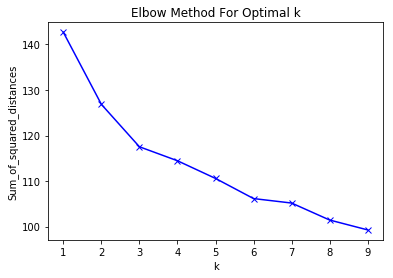

In [58]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Run k-means to cluster the neighborhood into 3 clusters.

In [59]:
# set number of clusters
kclusters = 3

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blr_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0,
       2, 2, 0, 0, 0, 0])

Filter Data for which Locality, the Foursquare API Get request url returns resulsts more thane 0. For some Localities such as Koramangala, Jigani etc, the API returns 0 results. So, we need to skip such Localities

In [60]:
blr_merged = bangalore_data.copy()
blr_merged = blr_merged[blr_merged.Locality.isin(neighborhoods_venues_sorted.Neighborhood)]
blr_merged.shape

(413, 4)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#blr_merged = df.copy()

#blr_merged.rename(columns = {'Locality':'Neighborhood'}, inplace = True)

# merge blr_grouped with bangalore_data to add latitude/longitude for each neighborhood/Locality
blr_merged = blr_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Locality')

blr_merged.head() # check the last columns!

,Locality,Avg_price_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
380,Hesarghatta Main Road,61538,13.098223,77.532626,2,Farm,Indian Restaurant,Resort,Wings Joint,Donut Shop,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
107,Thanisandra Main Road,56250,13.043249,77.625648,0,Cafeteria,Vegetarian / Vegan Restaurant,Andhra Restaurant,Multiplex,Wings Joint,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
204,Nagasandra,46875,13.047950,77.500135,0,Restaurant,Gas Station,Athletics & Sports,Gym / Fitness Center,Light Rail Station,Event Space,Eastern European Restaurant,Electronics Store,Event Service,Wings Joint
297,MG Road,38359,12.974185,77.612414,2,Indian Restaurant,Brewery,Chinese Restaurant,Hotel,Bookstore,Paella Restaurant,Restaurant,Café,Donut Shop,Pub
245,Sadashiva Nagar,35610,13.010619,77.632448,2,Paper / Office Supplies Store,Steakhouse,Indian Restaurant,Kerala Restaurant,Wings Joint,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant


**Finally, let's visualize the resulting clusters**

In [63]:
# Initiating a Folium map with Bangalore's longitude and latitude
map_clusters = folium.Map(location=[lat_blr, long_blr], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, loc, cluster, avg_price in zip(blr_merged['Latitude'], blr_merged['Longitude'], blr_merged['Locality'], blr_merged['Cluster Labels'], blr_merged['Avg_price_per_sqft']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup(str(loc) + ' Cluster ' + str(cluster) + ' INR/sqft ' + str(avg_price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhoods falls under the red (cluster 0) and green (cluster 2) while few are under the blue (cluster 1).

### Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

**Cluster 1**

In [64]:
blr_merged.loc[blr_merged['Cluster Labels'] == 0, blr_merged.columns[[1] + list(range(5, blr_merged.shape[1]))]]

,Avg_price_per_sqft,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
107,56250,Cafeteria,Vegetarian / Vegan Restaurant,Andhra Restaurant,Multiplex,Wings Joint,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
204,46875,Restaurant,Gas Station,Athletics & Sports,Gym / Fitness Center,Light Rail Station,Event Space,Eastern European Restaurant,Electronics Store,Event Service,Wings Joint
477,31391,Hotel,Indian Restaurant,Coffee Shop,French Restaurant,Restaurant,Café,Pub,Art Museum,Juice Bar,Snack Place
507,31250,Clothing Store,Indian Restaurant,Women's Store,Candy Store,Fast Food Restaurant,South Indian Restaurant,Market,Sporting Goods Shop,Burger Joint,Bar
291,31250,Café,Indian Restaurant,Pub,Bar,Vegetarian / Vegan Restaurant,Dessert Shop,Fast Food Restaurant,Andhra Restaurant,Pizza Place,Bakery
56,26692,Indian Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Pizza Place,Fast Food Restaurant,BBQ Joint,Chinese Restaurant,Tea Room,Snack Place,Juice Bar
320,26666,Park,Department Store,Bus Station,Wings Joint,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
401,26500,Vegetarian / Vegan Restaurant,Wings Joint,Donut Shop,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
359,26250,Indian Restaurant,Café,Ice Cream Shop,Snack Place,Coffee Shop,Seafood Restaurant,Sandwich Place,Burger Joint,Punjabi Restaurant,Pub
29,25238,Lounge,Café,Pub,Cupcake Shop,Italian Restaurant,Cocktail Bar,Restaurant,Ice Cream Shop,Indian Restaurant,Bakery


**Cluster 2**

In [65]:
blr_merged.loc[blr_merged['Cluster Labels'] == 1, blr_merged.columns[[1] + list(range(5, blr_merged.shape[1]))]]

,Avg_price_per_sqft,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
306,14583,ATM,Cricket Ground,Wings Joint,Eastern European Restaurant,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
6,11811,ATM,Campground,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
425,11500,ATM,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm
269,9166,ATM,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm
454,8000,ATM,Campground,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
386,8000,ATM,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm
285,7500,ATM,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm
242,7000,ATM,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm
163,5200,ATM,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm
187,3500,ATM,Campground,Wings Joint,Dry Cleaner,Fishing Store,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market


**Cluster 3**

In [66]:
blr_merged.loc[blr_merged['Cluster Labels'] == 2, blr_merged.columns[[1] + list(range(5, blr_merged.shape[1]))]]

,Avg_price_per_sqft,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
380,61538,Farm,Indian Restaurant,Resort,Wings Joint,Donut Shop,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
297,38359,Indian Restaurant,Brewery,Chinese Restaurant,Hotel,Bookstore,Paella Restaurant,Restaurant,Café,Donut Shop,Pub
245,35610,Paper / Office Supplies Store,Steakhouse,Indian Restaurant,Kerala Restaurant,Wings Joint,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant
476,35000,Indian Restaurant,Café,Hotel,Coffee Shop,Sandwich Place,Salad Place,Karnataka Restaurant,Middle Eastern Restaurant,Intersection,Dessert Shop
78,32222,Indian Restaurant,Café,Juice Bar,Chinese Restaurant,Women's Store,Sandwich Place,Restaurant,Fast Food Restaurant,Electronics Store,Pizza Place
53,32000,Hotel,Indian Restaurant,Light Rail Station,Café,Cosmetics Shop,Cricket Ground,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant
352,31500,Indian Restaurant,Café,Hotel,Coffee Shop,Sandwich Place,Salad Place,Karnataka Restaurant,Middle Eastern Restaurant,Intersection,Dessert Shop
461,30000,Indian Restaurant,Food Truck,Farmers Market,Dessert Shop,Italian Restaurant,Wings Joint,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio
90,29125,Indian Restaurant,Café,Tea Room,Restaurant,Indian Sweet Shop,Metro Station,Mediterranean Restaurant,Hookah Bar,Fast Food Restaurant,Farmers Market
346,25750,Tennis Stadium,Indian Restaurant,Capitol Building,Donut Shop,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market,Farm


**Distribution of the Clusters**

In [70]:
blr_merged['Cluster Labels'].value_counts()/blr_merged.shape[0]

0    0.590799
2    0.351090
1    0.058111
Name: Cluster Labels, dtype: float64

Visualize it

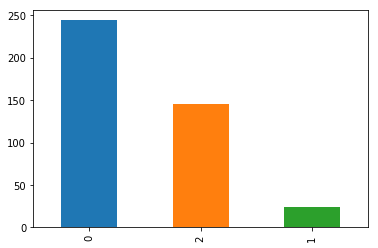

In [91]:
blr_merged['Cluster Labels'].value_counts().plot(kind='bar',x='Cluster',y='Count')

All the above analysis resulted that the real estate prices are high in localities where there is more proximity to amenities, peaceful conforming areas, neighborhood status, scenic views, transport hubs, markets, sport facilities and restaurants & bars etc.

## Conclusion

We conclude that this helps people to easily interpret where to live and invest with desirable amenities and affordable price in the neighborhoods of Bangalore.